# User reports
Reports are generated for users that subscribed to them through a Google form.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 12})

import numpy as np
import re
import json
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from pandas.io.json import json_normalize
from IPython.display import display
from pandas import DataFrame
import pandas as pd
from datetime import datetime, timedelta
import datetime

from subscribers import subscribers
import alerts

In [2]:
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
S = subscribers()
A = alerts.alerts()

## Searches

In [3]:
def user_jobs_aggregations(user, days):
    s = {
        "size": 0, 
        'query':{
            'bool':{
                'must':[
                    { "term": {"produsername":user } },
                    { 'range' : { 'modificationtime' : {"gte" : "now-"+str(days)+"d"} }                
                    }
                ]
            }
        },
        "aggs": {
            "jobstatus":{
                "terms": { 
                    "field": "jobstatus",
                    "size": 5,
                    "order": {
                      "_count": "desc"
                    }
                }
            }, 
            "cpueff": {
              "avg": {
                "script": {
                  "inline": "(doc['actualcorecount'].value) ? doc['cpu_eff'].value*100/doc['actualcorecount'].value : 0",
                  "lang": "expression"
                }
              }
            },
            "inputfilebytes": {
              "sum": {
                "field": "inputfilebytes"
              }
            },
            "outputfilebytes": {
              "sum": {
                "field": "outputfilebytes"
              }
            },
            "walltimespent": {
              "sum": {
                "script": {
                  "inline": "def core=doc['actualcorecount'].value; if (core!=null) {return doc['wall_time'].value * core} else {return doc['wall_time'].value}",
                  "lang": "painless"
                }
              }
            },
            "cputimespent": {
              "sum": {
                "field": "cpuconsumptiontime"
              }
            },
            "tasks": {
              "cardinality": {
                "field": "jeditaskid"
              }
            },
            "evps": {
              "avg": {
                "script": {
                  "inline": "(doc['nevents'].value && doc['actualcorecount'].value && doc['wall_time'].value) ? doc['nevents'].value/doc['wall_time'].value/doc['actualcorecount'].value : 0",
                  "lang": "expression"
                }
              }
            }
        }
    }

    res = es.search(index="jobs", body=s, request_timeout=12000)
#     print(res) 

    if res['hits']['total']==0: return ''
    
    jobs=res['hits']['total']
    tasks=res['aggregations']['tasks']['value']
    cpueff=res['aggregations']['cpueff']['value']
    infile=res['aggregations']['inputfilebytes']['value']
    outfile=res['aggregations']['outputfilebytes']['value']
    evps=res['aggregations']['evps']['value']
    cputime=res['aggregations']['cputimespent']['value']
    walltime=res['aggregations']['walltimespent']['value']
    jstatus = res['aggregations']['jobstatus']['buckets']

    #create df
    df_w = json_normalize(jstatus)
    df_w = df_w.set_index('key')
    print(df_w)

    fig1, ax1 = plt.subplots()
    ax1.pie(df_w, labels=df_w.index, autopct='%1.1f%%', shadow=False, startangle=90)
    ax1.axis('equal')
    fig1.set_size_inches(6, 6)
    
#     plt.tight_layout()
    plt.savefig('Images/'+user+'_job_eff.png')
#     plt.show()
    
    text = '<BR>Some important numbers:<BR>'
    text += '<B>Jobs: </B>'+str(jobs)+'<BR>'
    text += '<B>Tasks: </B>'+str(tasks)+'<BR>'
    text += '<B>CPU efficiency: </B>'+str(round(cpueff, 2))+'<BR>'
    text += '<B>CPU time: </B>'+str(round(cputime/3600,2))+' hours<BR>'
    text += '<B>Walltime: </B>'+str(round(walltime/3600,2))+' hours<BR>'
    text += '<B>Input data processed:</B>'+str(round(infile/1024/1024/1024,2))+' GB<BR>'
    text += '<B>Data produced: </B>'+str(round(outfile/1024/1024/1024,2))+' GB<BR>'
    text += '<B>Processing rate: </B>'+str(round(evps,2))+'[events/s]<BR>'
    return text

In [4]:
def user_memory_aggregations(user, days):
    s = {
        "size": 0, 
        'query':{
            'bool':{
                'must':[
                    { "term": {"produsername":user } },
                    { 'range' : { 'modificationtime' : {"gte" : "now-"+str(days)+"d"} }                
                    }
                ]
            }
        },
        "aggs": {
            "jobstatus":{
                "terms": { 
                    "field": "jobstatus",
                    "size": 5,
                    "order": {
                      "_count": "desc"
                    }
                },
                "aggs": {
                    "pss": {
                      "avg": {
                        "field": "avgpss"
                      }
                    },
                    "rss": {
                      "avg": {
                        "script": {
                          "inline": "def avgrss = doc['avgrss'].value; if(avgrss!=null) {return avgrss/1024;} else {return 0;}",
                          "lang": "painless"
                        }
                      }
                    },
                    "swap": {
                      "avg": {
                        "script": {
                          "inline": "def avgswap = doc['avgswap'].value; if(avgswap!=null) {return avgswap/1024;} else {return 0;}",
                          "lang": "painless"
                        }
                      }
                    },
                    "vmem": {
                      "avg": {
                        "script": {
                          "inline": "def avgvmem = doc['avgvmem'].value; if(avgvmem!=null) {return avgvmem/1024;} else {return 0;}",
                          "lang": "painless"
                        }
                      }
                    },
                    "maxpss": {
                      "avg": {
                        "script": {
                          "inline": "def maxpss = doc['maxpss'].value; if(maxpss!=null) {return maxpss/1024;} else {return 0;}",
                          "lang": "painless"
                        }
                      }
                    }
                }
            }
        }
    }

    res = es.search(index="jobs", body=s, request_timeout=12000)
#     print(res) 
    
    if res['hits']['total']==0: return ''
    
    jstatus = res['aggregations']['jobstatus']['buckets']

    #create df
    df_w = json_normalize(jstatus)
    df_w = df_w.set_index('key')
    df_w.columns = [w.replace('.value', '') for w in df_w.columns]
    df_w.columns = [w.replace('doc_count', 'jobs') for w in df_w.columns]
    df_w['pss'] = df_w['pss']/1024/1024
    df_w = df_w.round(decimals=0)
    print(df_w)

    return df_w.to_html(col_space=5, border=0 )


In [5]:
def user_IO_aggregations(user, days):
    s = {
        "size": 0, 
        'query':{
            'bool':{
                'must':[
                    { "term": {"produsername":user } },
                    { 'range' : { 'modificationtime' : {"gte" : "now-"+str(days)+"d"} }                
                    }
                ]
            }
        },
        "aggs": {
            "jobstatus":{
                "terms": { 
                    "field": "jobstatus",
                    "size": 5,
                    "order": {
                      "_count": "desc"
                    }
                },
                "aggs": {
                     "Input size": {
                          "avg": {
                            "field": "inputfilebytes"
                          }
                        },
                    "Actually read": {
                      "avg": {
                        "script": {
                          "inline": "def IObytesRead = doc['IObytesRead'].value; if(IObytesRead!=null) {return IObytesRead/1024;} else {return 0;}",
                          "lang": "painless"
                        }
                      }
                    }
                }
            }
        }
    }

    res = es.search(index="jobs", body=s, request_timeout=12000)
#     print(res) 
    if res['hits']['total']==0: return 0
    
    jstatus = res['aggregations']['jobstatus']['buckets']

    #create df
    df_w = json_normalize(jstatus)
    df_w = df_w.set_index('key')
    df_w.columns = [w.replace('.value', '') for w in df_w.columns]
    df_w.columns = [w.replace('doc_count', 'jobs') for w in df_w.columns]
    df_w['Input size'] = df_w['Input size']/1024/1024
    df_w = df_w.round(decimals=0)
    print(df_w)
    
    df_w.plot.bar(y=['Input size','Actually read'])
    plt.savefig('Images/'+user+'_io_eff.png')
#     plt.show()
    return 1

In [6]:
def user_disk_aggregations(user, days):
    s = {
        "size": 0, 
        "query":{
            "bool":{
                "must":[
                    { "term": {"owner" : user } },
                    { "range" : { "timestamp" : {"gte" : "now-"+str(days)+"d"} }                
                    }
                ]
            }
        }
        ,
        "aggs": {
            "dtype": {
              "terms": {
                "field": "dtype",
                "size": 10,
                "order": {
                  "size": "desc"
                  }
                },
            "aggs": {
                "size": {
                  "sum": {
                    "field": "size"
                  }
                }
              ,
        "site": {
          "terms": {
            "field": "site",
            "size": 5,
            "order": {
              "subsize": "desc"
            }
          },
          "aggs": {
            "subsize": {
              "sum": {
                "field": "size"
              }
            }
          }
        }}
            }
        }
    }
    
    res = es.search(index="ddm_aggregated_2018.05", body=s, request_timeout=12000)
    
    if res['hits']['total']==0: return 0
    
    jstatus = res['aggregations']['dtype']['buckets']
    
    
    tot=0
    dtype=[]
    site=[]
    size=[]
    for l in jstatus:
        tot += l['size']['value']
        for ss in l['site']['buckets']:
            dtype.append(l['key'])
            site.append(ss['key'])
            size.append(ss['subsize']['value']/1024/1024/1024)
    
    df=pd.DataFrame({"type":dtype,"site":site,"size":size})
    category_group = df.groupby(['site','type']).sum()
    print(category_group)
    
    pl = category_group.unstack().plot(kind='bar',stacked=True,figsize=(9, 7))
    pl.set_xlabel("Sites")
    pl.set_ylabel("Size [GB]")
    l = category_group.index.levels[1]
    pl.legend(l)

    plt.savefig('Images/'+user+'_diskspace.png')
#     plt.show()
    return tot/1024/1024/1024
    

user name:Ilija Vukotic  email:ilijav@gmail.com  rucio:dhirsch
['Summary', 'Efficiency', 'Memory', 'Disk space'] ['Daily', 'Weekly'] False
          doc_count
key                
finished      99011
closed        64170
failed        14185
merging         274


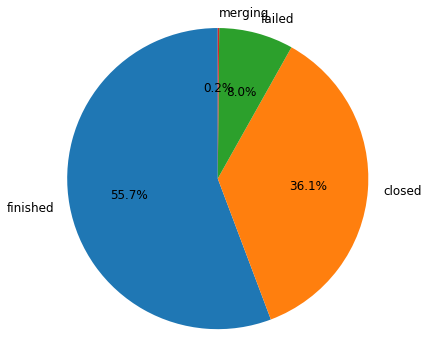

          Actually read  Input size   jobs
key                                       
finished         7497.0      3040.0  99011
closed              6.0      3095.0  64170
failed          16458.0      3023.0  14185
merging          1923.0       409.0    274


/usr/lib64/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


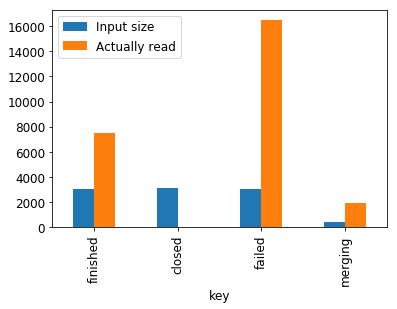

           jobs  maxpss  pss      rss   swap     vmem
key                                                  
finished  99011  2416.0  2.0   7325.0   54.0  10449.0
closed    64169    10.0  0.0     74.0    0.0    111.0
failed    14185  1538.0  1.0   3376.0    8.0   5095.0
merging     274  4103.0  3.0  19936.0  181.0  26210.0
                               size
site          type                 
DESY-HH       unknown  14786.383691
FZK-LCG2      unknown  21334.492210
WUPPERTALPROD unknown  14048.891551


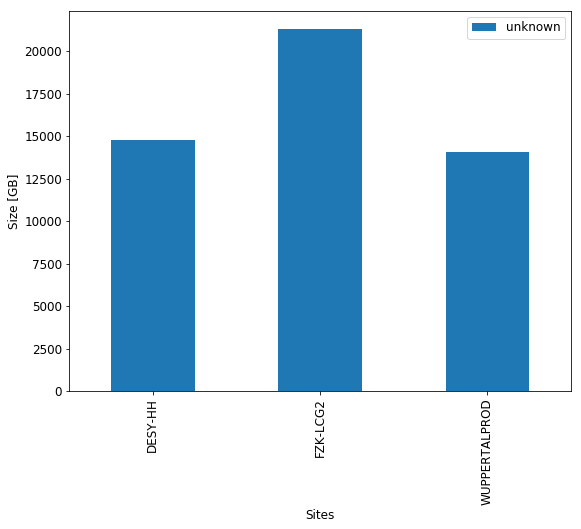

user name:Johannes Elmsheuser  email:elmsheuser@gmail.com  rucio:elmsheus
['Summary', 'Efficiency', 'Memory', 'Disk space'] ['Daily', 'Weekly'] False
                             size
site      type                   
CERN-PROD unknown        0.005696
LRZ-LMU   AOD         2104.534344
          NTUP_SMWZ  23793.406009
          NTUP_TRIG    527.925535
          RAW          848.675103
          unknown     1617.430401


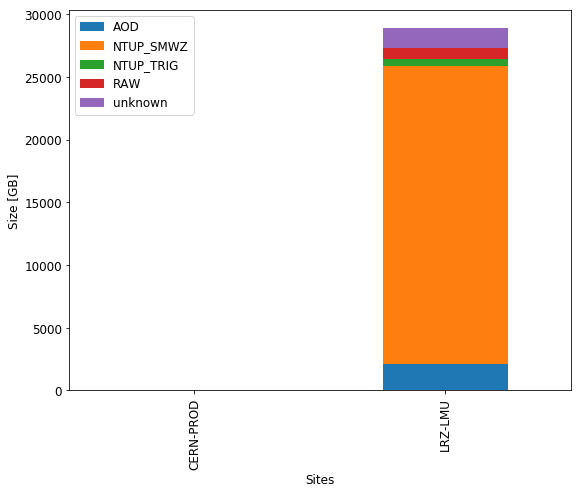

In [7]:
days=1
for user in S.get_all_users():
    print(user.to_string())
    print(user.jobs, user.intervals, user.comparisons)
    
    imgs=[]
    txt = user_jobs_aggregations(user.rucio_username, days)
    
    body = 'Dear ' + user.name+',\n\n'
    body += '<BR>here a summary of your Grid resource you utilized.<BR>'
    
    if 'Summary' in user.jobs:
        if txt=='' :
            body+='<BR>You did not run any grid jobs in this period.'
        else:
            body += txt
        
    if 'Efficiency' in user.jobs:
        if txt!='':
            imgs.append({
                "Title":'Job efficiency',
                "Description":" You should try to have as small as possible fraction of Failed jobs. Canceled and Closed jobs are a feature of the production system.",
                "Filename":"Images/"+user.rucio_username+"_job_eff.png",
                "Link":"http://atlas-kibana.mwt2.org/app/kibana#/dashboard/29a93670-5d12-11e8-99dd-1dc03b06e504"
            })
        ret = user_IO_aggregations(user.rucio_username, days)
        if ret>0:
            imgs.append({
                "Title":'Jobs IO',
                "Description":"values are in MB. When less than a tenth of data is actually read, you might want to think of prefiltering the data. Reading 100% of data frequently means you use ReadEvent for all events and that is also not good practice.",
                "Filename":"Images/"+user.rucio_username+"_io_eff.png",
                "Link":"http://atlas-kibana.mwt2.org/app/kibana#/dashboard/3ce37050-5d2d-11e8-99dd-1dc03b06e504"
            })
    
    if 'Memory' in user.jobs:
        txt = user_memory_aggregations(user.rucio_username, days)
        if len(txt)>0:
            body += "<BR><H3>Memory consumption</H3><BR>"
            body += "All values are in MB<BR>"
            body += txt
        
    if 'Disk space' in user.jobs:
        tot = user_disk_aggregations(user.rucio_username, days)
        if tot>0:
            body += "<BR><B>Total disk space used: </B>"+str(round(tot,2))+" GB<BR>"
            imgs.append({
                "Title":'Disk space',
                "Description":"here split is per site and data type. When unable to determine the type from filename, it is gruped in Unknown category.",
                "Filename":"Images/"+user.rucio_username+"_diskspace.png",
                "Link":"http://atlas-kibana.mwt2.org/app/kibana#/dashboard/13638e80-5d3d-11e8-99dd-1dc03b06e504"
            })
    
    A.send_HTML_mail(
        'Grid Resource Utilization',
        user.email,
        body,
        subtitle='Daily report',
        images=imgs
    )

# for days in [1,7]:
#     print ("interval:",days)
    
    